# Validation Track B: Credit Risk Analysis
This notebook contains the validation logic for the LOQI Credit Risk model, focusing on Class Imbalance and Sim-to-Real transfer using Qrisp.

In [ ]:
# MY UMUT CODE STARTS HERE

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,24,70000,RENT,0.0,MEDICAL,C,6425,13.72,0,0.09,N,2
1,33,44784,RENT,2.0,EDUCATION,D,10000,NaN,1,0.22,N,6
2,46,102000,RENT,0.0,PERSONAL,C,15000,13.22,0,0.15,Y,17
3,25,66420,MORTGAGE,1.0,EDUCATION,B,4000,12.18,0,0.06,N,2
4,24,95000,MORTGAGE,7.0,DEBTCONSOLIDATION,B,15000,12.69,0,0.16,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,24,41000,RENT,4.0,EDUCATION,A,10000,6.99,0,0.24,N,4
2996,25,90000,MORTGAGE,9.0,HOMEIMPROVEMENT,A,10000,5.42,0,0.11,N,4
2997,23,28000,RENT,8.0,DEBTCONSOLIDATION,A,8000,7.74,0,0.29,N,4
2998,23,80000,RENT,5.0,EDUCATION,A,8000,7.90,0,0.10,N,3


person_emp_length mode 0.0
person_emp_length median 4.0
loan_int_rate mode 5.42
loan_int_rate median 10.99


/tmp/ipython-input-557571750.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  credit_df['person_emp_length'].fillna(credit_df['person_emp_length'].mode()[0], inplace=True)
/tmp/ipython-input-557571750.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 

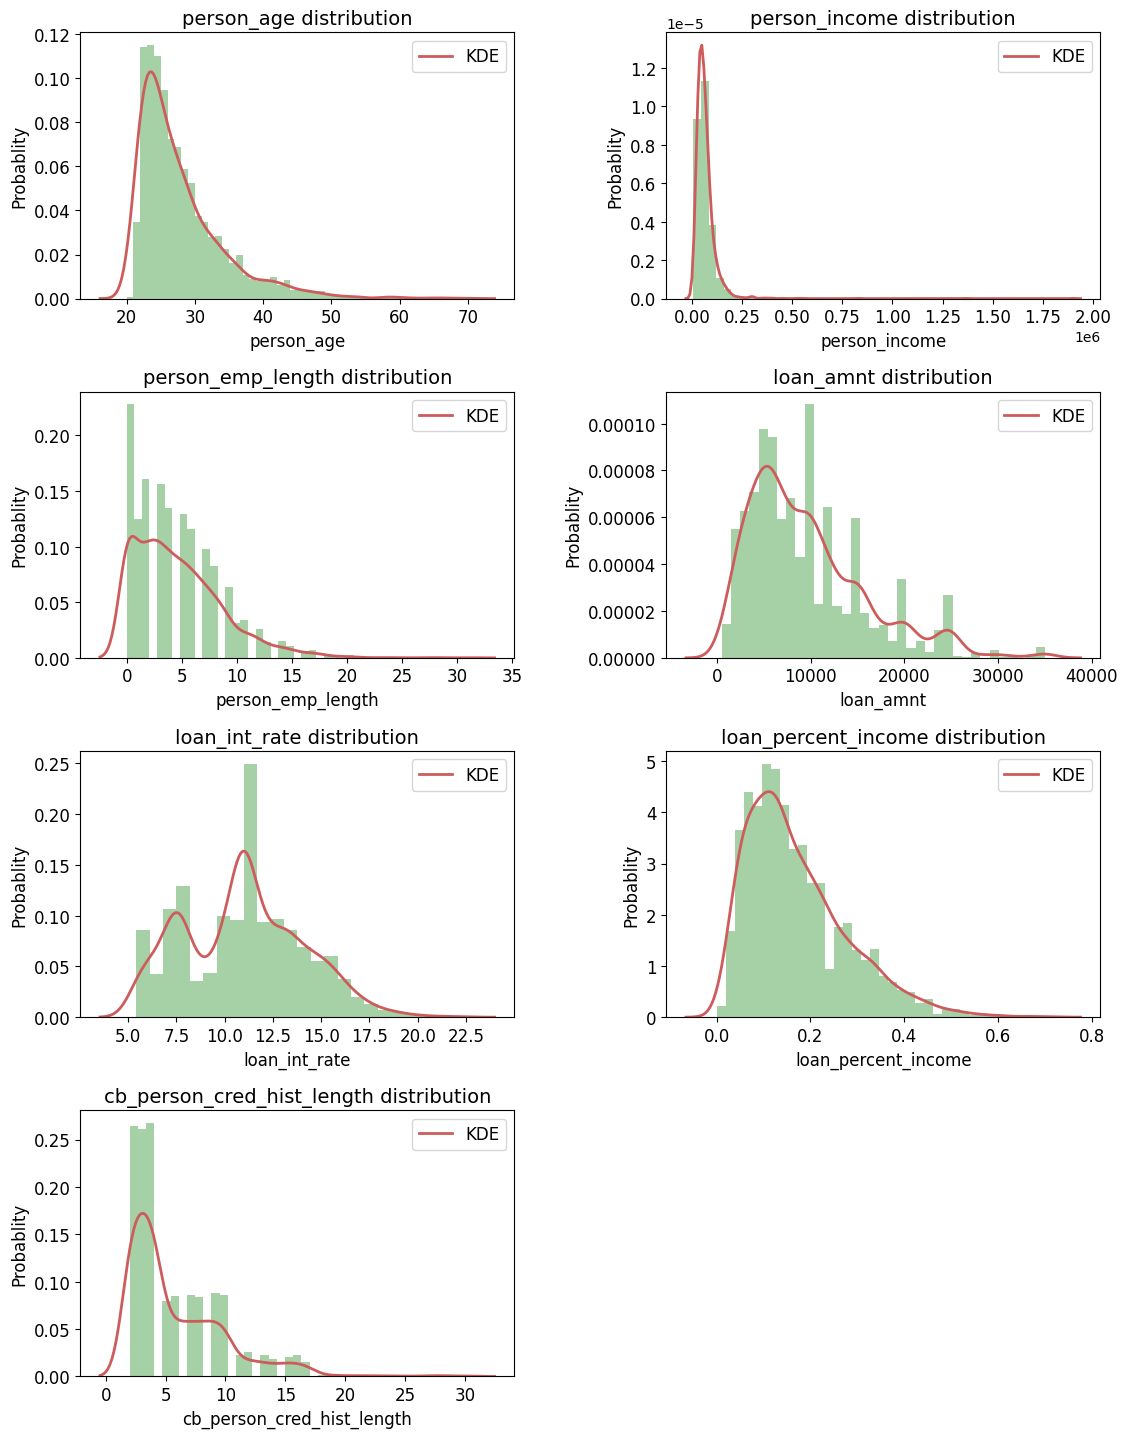

The cleaned dataset has 3000 rows and 27 columns
The cleaned dataset has 7 numerical features and 19 categorical features
Quantum Input Shape: (2100, 4)


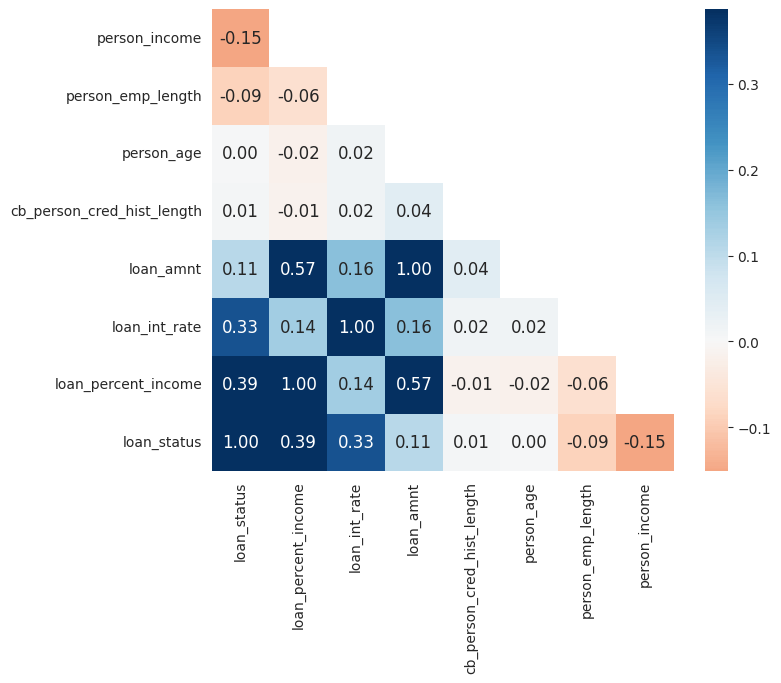

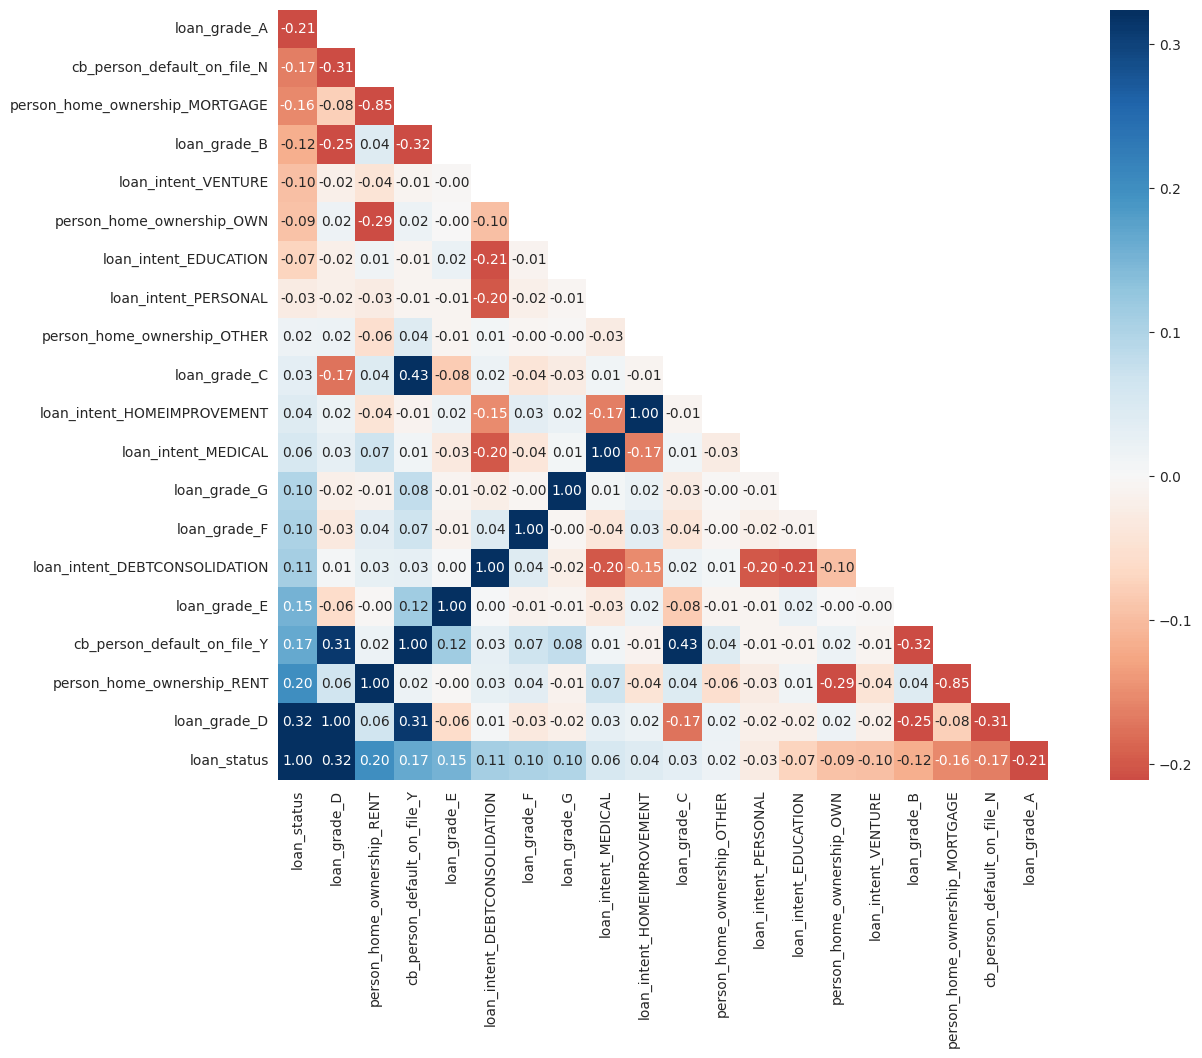

In [5]:

# import libraries and packages
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn import model_selection,linear_model, metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

"""## Exploratory Analysis <a class='anchor' id='Section_2'>"""

# read data into a DataFrame
credit_df = pd.read_csv("credit_risk_dataset_red.csv")
display(credit_df)

# check the data size
credit_df.shape

Nan_per = credit_df.isnull().sum()/credit_df.shape[0]*100
Nan_per.round(2)

"""**Observation:**
* Only two columns of data contains NaN,
* `person_emp_length` contains **2.75%** NaN and `loan_int_rate` contains **9.56%** NaN
"""

# check the mode, median for the two features
print('person_emp_length mode {}'.format(credit_df['person_emp_length'].mode()[0]))
print('person_emp_length median {}'.format(credit_df['person_emp_length'].median()))
print('loan_int_rate mode {}'.format(credit_df['loan_int_rate'].mode()[0]))
print('loan_int_rate median {}'.format(credit_df['loan_int_rate'].median()))

"""**Observation:**
* `person_emp_length` is the person employment history, to be more conservative, the nan values are replaced with mode, which is 0 year.
* `loan_int_rate` is the loan income rate, to be more conservative, the nan values are replaced with 10.99, which is the median
"""

# fill NaN with the mode
credit_df['person_emp_length'].fillna(credit_df['person_emp_length'].mode()[0], inplace=True)
credit_df['loan_int_rate'].fillna(credit_df['loan_int_rate'].median(), inplace=True)

# check the nans are replaced
credit_df.isnull().sum()

# numerical variebles
num_cols = pd.DataFrame(credit_df[credit_df.select_dtypes(include=['float', 'int']).columns])
# print the numerical variebles
num_cols.columns

# drop the label column 'loan status' before visualization
num_cols_hist = num_cols.drop(['loan_status'], axis=1)
# visualize the distribution for each varieble
plt.figure(figsize=(12,16))

for i, col in enumerate(num_cols_hist.columns):
    idx = int('42'+ str(i+1))
    plt.subplot(idx)
    sns.distplot(num_cols_hist[col], color='forestgreen',
                 kde_kws={'color': 'indianred', 'lw': 2, 'label': 'KDE'})
    plt.title(col+' distribution', fontsize=14)
    plt.ylabel('Probablity', fontsize=12)
    plt.xlabel(col, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(['KDE'], prop={"size":12})

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,
                    wspace=0.35)
plt.show()

# decribe the dataset
credit_df.describe()

"""**Observation:** All of the distributions are positive skewed.

* `person_age`: Most people are 20 to 60 years old. In the following analysis, to be more general, people age > 100 will be droped.
* `person_emp_length`: Most people have less than 40 years of employment. People with employment > 60 years will be droped.
* `person_income`: It seems that there are outliers which has to be removed (> 4 million).
* For all other variables, the distribution is more uniform across the whole range, thus they will be kept.

"""

# clean the dataset and drop outliers
cleaned_credit_df = credit_df[credit_df['person_age']<=100]
cleaned_credit_df = cleaned_credit_df[cleaned_credit_df['person_emp_length']<=60]
cleaned_credit_df = cleaned_credit_df[cleaned_credit_df['person_income']<=4e6]

# get the cleaned numberical variebles
cleaned_num_cols = pd.DataFrame(cleaned_credit_df[cleaned_credit_df.select_dtypes(include=['float', 'int']).columns])

corr = cleaned_num_cols.corr().sort_values('loan_status', axis=1, ascending=False)
corr = corr.sort_values('loan_status', axis=0, ascending=True)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 6))
    ax = sns.heatmap(corr, mask=mask, vmin=corr.loan_status.min(),
                     vmax=corr.drop(['loan_status'], axis=0).loan_status.max(),
                     square=True, annot=True, fmt='.2f',
                     center=0, cmap='RdBu',annot_kws={"size": 12})

"""**Observation:**

* `person_income`, `person_emp_length`, and `person_age`: has negative effect on loan_status being default, which means the larger these variebles, the less likely the person is risky.
* `loan_percent_income`, `loan_int_rate`, and `loan_amnt`: has postive effect on loan_status being default, which means the larger these variebles, the more likely the person is risky.
"""

# get the categorical variebles
cat_cols = pd.DataFrame(cleaned_credit_df[cleaned_credit_df.select_dtypes(include=['object']).columns])
cat_cols.columns

# one-hot encode the catogorical variebles
encoded_cat_cols = pd.get_dummies(cat_cols)
cat_cols_corr = pd.concat([encoded_cat_cols, cleaned_credit_df['loan_status']], axis=1)
corr = cat_cols_corr.corr().sort_values('loan_status', axis=1, ascending=False)
corr = corr.sort_values('loan_status', axis=0, ascending=True)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(corr, mask=mask, vmin=corr.loan_status.min(),
                     vmax=corr.drop(['loan_status'], axis=0).loan_status.max(),
                     square=True, annot=True, fmt='.2f',
                     center=0, cmap='RdBu',annot_kws={"size": 10})

# concat the numerical and one-hot encoded categorical variebles
cleaned_credit_df = pd.concat([cleaned_num_cols, encoded_cat_cols], axis=1)
cleaned_credit_df.head()

# check the cleaned dataset size
print ('The cleaned dataset has {} rows and {} columns'.format(cleaned_credit_df.shape[0],
                                                               cleaned_credit_df.shape[1]))
print ('The cleaned dataset has {} numerical features and {} categorical features'
       .format(len(cleaned_num_cols.columns)-1, len(encoded_cat_cols.columns)))

# --- 1. Classical Preprocessing ---
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Use your existing 'cleaned_credit_df'
X = cleaned_credit_df.drop('loan_status', axis=1).values
y = cleaned_credit_df['loan_status'].values

# 1. Standardize first
X_scaled = StandardScaler().fit_transform(X)

# 2. Reduce to 4 features (for 4 Qubits) using PCA
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

# 3. Scale to [0, PI] for Quantum Rotation Encoding
minmax = MinMaxScaler(feature_range=(0, np.pi))
X_final = minmax.fit_transform(X_pca)

# Split data (Subsample for demonstration speed if needed)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42)

print(f"Quantum Input Shape: {X_train.shape}")

--- 1. Preparing Data ---
Training Data Size: 2100
Testing Data Size:  900

--- Starting Training (Simulation) ---
Iter 1: Loss=0.4687 | Acc=0.202 | AUC=0.320 | Gini=-0.361
Iter 2: Loss=0.5030 | Acc=0.193 | AUC=0.342 | Gini=-0.316
Iter 3: Loss=0.3987 | Acc=0.210 | AUC=0.327 | Gini=-0.347
Iter 4: Loss=0.5183 | Acc=0.198 | AUC=0.344 | Gini=-0.312
Iter 5: Loss=0.3987 | Acc=0.210 | AUC=0.327 | Gini=-0.347
Iter 6: Loss=0.3987 | Acc=0.210 | AUC=0.327 | Gini=-0.347
Iter 7: Loss=0.3987 | Acc=0.210 | AUC=0.327 | Gini=-0.347
Iter 8: Loss=0.3987 | Acc=0.210 | AUC=0.327 | Gini=-0.347
Iter 9: Loss=0.5010 | Acc=0.207 | AUC=0.339 | Gini=-0.322
Iter 10: Loss=0.3987 | Acc=0.210 | AUC=0.327 | Gini=-0.347
Iter 11: Loss=0.3987 | Acc=0.210 | AUC=0.327 | Gini=-0.347
Iter 12: Loss=0.3987 | Acc=0.210 | AUC=0.327 | Gini=-0.347
Iter 13: Loss=0.3987 | Acc=0.210 | AUC=0.327 | Gini=-0.347
Iter 14: Loss=0.3987 | Acc=0.210 | AUC=0.327 | Gini=-0.347
Iter 15: Loss=0.3987 | Acc=0.210 | AUC=0.327 | Gini=-0.347
Iter 16: 

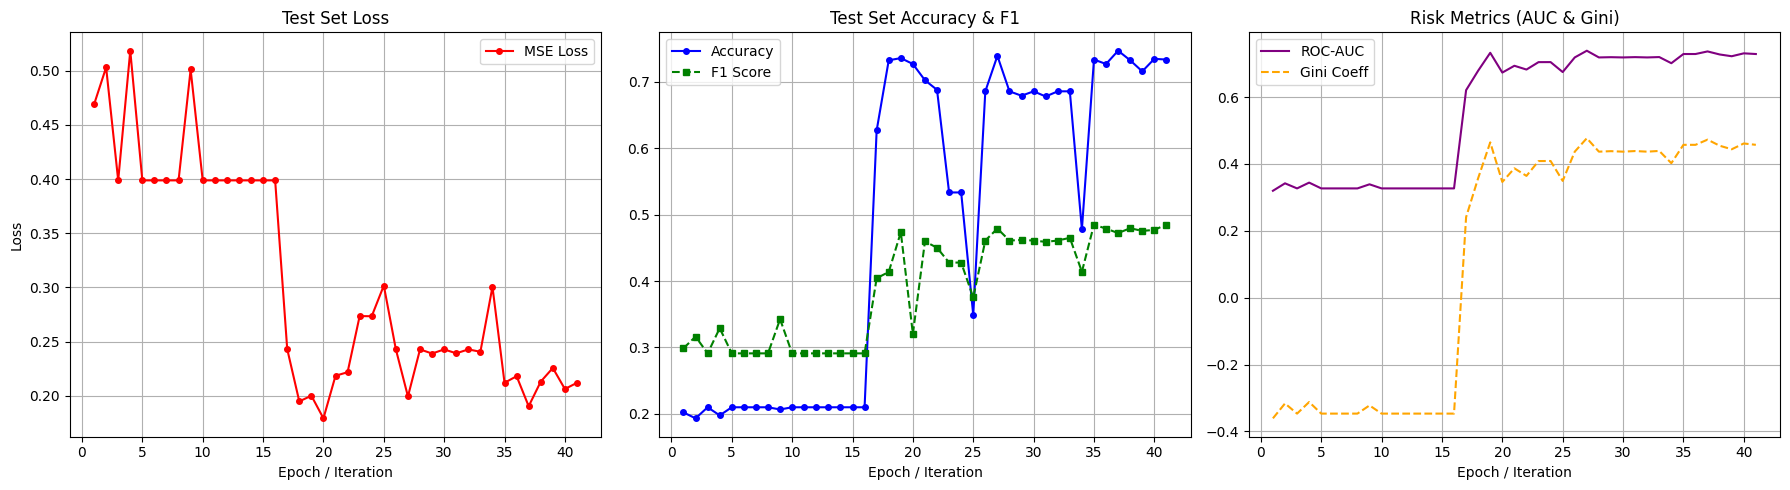


=== FINAL TEST RESULTS (900 Samples) ===
Accuracy: 0.7333
F1 Score: 0.4850
ROC-AUC:  0.7285
Gini:     0.4570


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from scipy.optimize import minimize
from qrisp import QuantumVariable, ry, rz, cx, auto_uncompute
import time
import matplotlib.pyplot as plt

# --- 1. PREPARE DATA ---
print("--- 1. Preparing Data ---")
# Ensure we use the cleaned dataframe from your environment
X = cleaned_credit_df.drop('loan_status', axis=1).values
y = cleaned_credit_df['loan_status'].values

# Scale, PCA, and Normalize
# 1. Standardize (Mean=0, Var=1)
X_scaled = StandardScaler().fit_transform(X)
# 2. PCA (Reduce to 4 features for 4 Qubits)
ipca = IncrementalPCA(n_components=4, batch_size=256)

# incremental fit in batches
ipca.fit(X_scaled)

# transform
X_pca = ipca.transform(X_scaled)
# 3. MinMax (Scale to 0 to pi for rotation angles)
minmax = MinMaxScaler(feature_range=(0, np.pi))
X_final = minmax.fit_transform(X_pca)

# Split Data: 2100 Train, 900 Test
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42)

print(f"Training Data Size: {len(X_train)}")
print(f"Testing Data Size:  {len(X_test)}")

# --- 2. DEFINE QUANTUM MODEL ---
num_qubits = 4
depth = 2

def qrisp_circuit(data_point, params):
    qv = QuantumVariable(num_qubits)

    # Feature Map (Encoding)
    for i in range(num_qubits):
        ry(data_point[i], qv[i])

    # Ansatz (Trainable Layers)
    param_idx = 0
    for d in range(depth):
        # Entanglement
        for i in range(num_qubits - 1):
            cx(qv[i], qv[i+1])
        # Rotations
        for i in range(num_qubits):
            ry(params[param_idx], qv[i])
            rz(params[param_idx + 1], qv[i])
            param_idx += 2

    # Measure
    res = qv.get_measurement()

    # Marginalize (Probability of Qubit 0 being '1')
    prob_1 = 0.0
    for outcome_str, p in res.items():
        if outcome_str[0] == "1":
            prob_1 += p

    return prob_1

# Helper for fast batch prediction
def predict_batch(X_batch, params):
    # Runs the circuit for a list of data points
    preds = []
    for point in X_batch:
        preds.append(qrisp_circuit(point, params))
    return np.array(preds)

#--- COST FUNCTION ---
CLASS_WEIGHT_1 = 4.0
def cost_function(params, X_full, y_full, batch_size=200):
    # 1. Sample Batch
    indices = np.random.choice(len(X_full), batch_size, replace=False)
    X_batch = X_full[indices]
    y_batch = y_full[indices]

    # 2. Predict
    preds = predict_batch(X_batch, params)

    # 3. Define Weights
    # If the true label is 1 (Default), apply higher weight.
    # If the true label is 0 (Safe), weight is 1.0.
    weights = np.where(y_batch == 1, CLASS_WEIGHT_1, 1.0)

    # 4. Weighted MSE
    # We multiply the error by the weight before averaging
    squared_errors = (preds - y_batch) ** 2
    weighted_mse = np.mean(weights * squared_errors)

    return weighted_mse

# --- 4. CALLBACK (LIVE TRACKING) ---
# Stores history of metrics
history = {
    'iteration': [], 'loss': [], 'accuracy': [],
    'f1': [], 'auc': [], 'gini': []
}

def tracking_callback(params):
    iteration = len(history['iteration']) + 1

    # Run inference on the FULL 900 Test Set
    # Note: On a simulator, 900 samples takes ~1-2 seconds.
    y_probs = predict_batch(X_test, params)
    y_preds = np.where(y_probs > 0.5, 1, 0)

    # Calculate Metrics
    loss = np.mean((y_probs - y_test) ** 2)
    acc = accuracy_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds, zero_division=0)

    try:
        auc = roc_auc_score(y_test, y_probs)
        gini = 2 * auc - 1
    except ValueError:
        auc = 0.5
        gini = 0.0

    # Store
    history['iteration'].append(iteration)
    history['loss'].append(loss)
    history['accuracy'].append(acc)
    history['f1'].append(f1)
    history['auc'].append(auc)
    history['gini'].append(gini)

    # Print progress
    print(f"Iter {iteration}: Loss={loss:.4f} | Acc={acc:.3f} | AUC={auc:.3f} | Gini={gini:.3f}")

# --- 5. EXECUTE TRAINING ---
print("\n--- Starting Training (Simulation) ---")
total_params = num_qubits * 2 * depth
init_params = np.random.uniform(0, 2*np.pi, total_params)

start_time = time.time()

# We use COBYLA optimizer
result = minimize(
    cost_function,
    init_params,
    args=(X_train, y_train),
    method='COBYLA',
    callback=tracking_callback,
    options={'maxiter': 40, 'disp': False} # 40 Iterations
)

end_time = time.time()
print(f"\nTraining Complete in {end_time - start_time:.2f}s")
print(f"Optimal Parameters: {result.x}")

# --- 6. VISUALIZE METRICS ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Loss
axes[0].plot(history['iteration'], history['loss'], 'r-o', markersize=4, label='MSE Loss')
axes[0].set_title('Test Set Loss')
axes[0].set_xlabel('Epoch / Iteration')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

# Plot 2: Accuracy & F1
axes[1].plot(history['iteration'], history['accuracy'], 'b-o', markersize=4, label='Accuracy')
axes[1].plot(history['iteration'], history['f1'], 'g--s', markersize=4, label='F1 Score')
axes[1].set_title('Test Set Accuracy & F1')
axes[1].set_xlabel('Epoch / Iteration')
axes[1].grid(True)
axes[1].legend()

# Plot 3: AUC & Gini
axes[2].plot(history['iteration'], history['auc'], 'purple', label='ROC-AUC')
axes[2].plot(history['iteration'], history['gini'], 'orange', linestyle='--', label='Gini Coeff')
axes[2].set_title('Risk Metrics (AUC & Gini)')
axes[2].set_xlabel('Epoch / Iteration')
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()

# Final Report
print("\n=== FINAL TEST RESULTS (900 Samples) ===")
print(f"Accuracy: {history['accuracy'][-1]:.4f}")
print(f"F1 Score: {history['f1'][-1]:.4f}")
print(f"ROC-AUC:  {history['auc'][-1]:.4f}")
print(f"Gini:     {history['gini'][-1]:.4f}")


--- Preparing Data ---
Train size: 2100 | Test size: 900
🔁 Resuming from checkpoint...

🚀 Running REAL IQM inference on 900 samples


100%|██████████| 900/900 [00:00<00:00, 844490.74it/s]

✅ Inference finished in 0.0 seconds

📊 REAL IQM HARDWARE RESULTS
Accuracy: 0.7156
F1-score: 0.5152
ROC-AUC:  0.7458
Gini:     0.4917

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.72      0.80       704
           1       0.41      0.69      0.52       196

    accuracy                           0.72       900
   macro avg       0.65      0.71      0.66       900
weighted avg       0.79      0.72      0.74       900



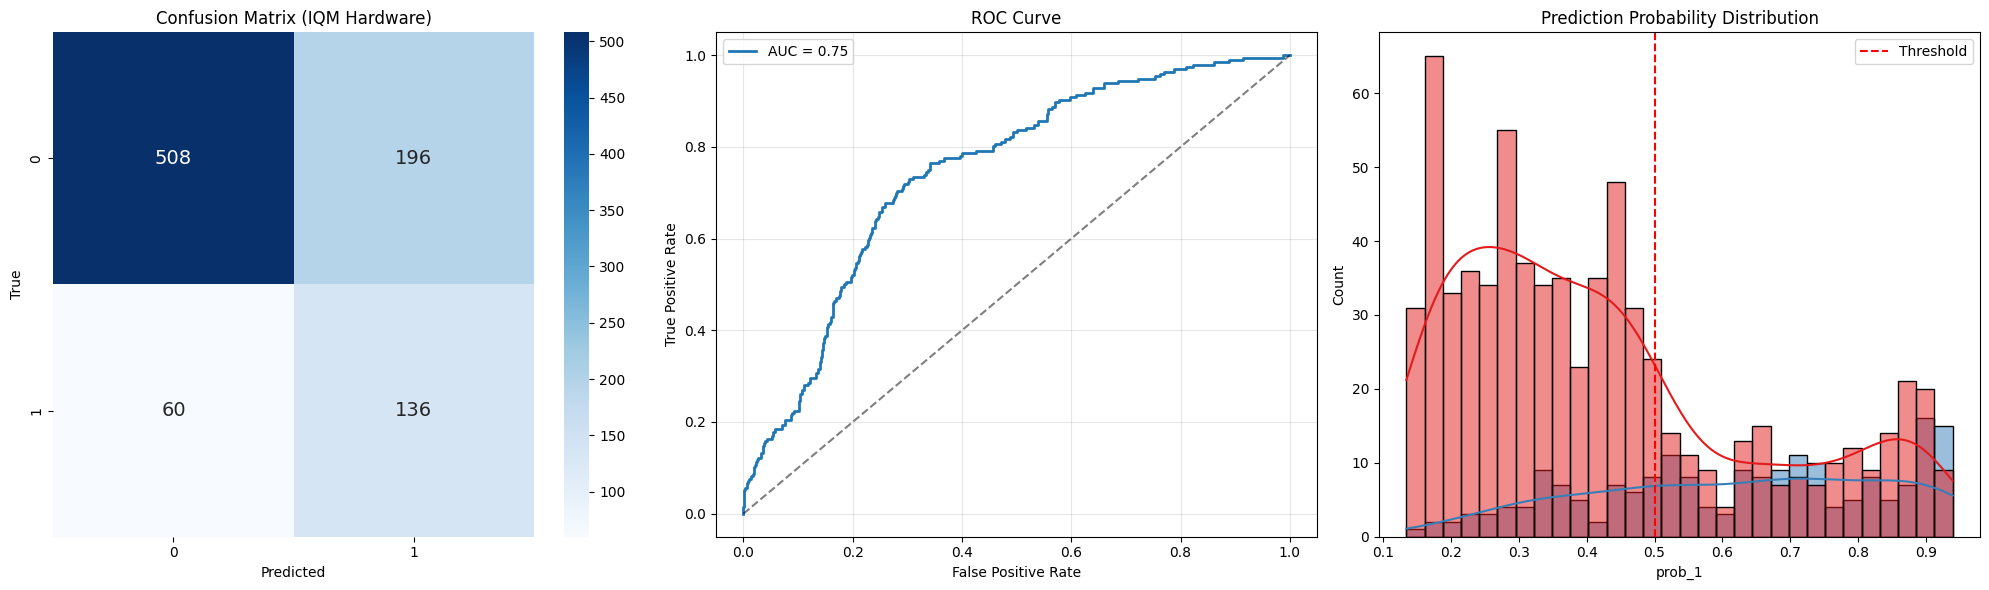

In [21]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report,
    roc_curve
)

from qrisp import QuantumVariable, ry, rz, cx
from tqdm import tqdm

optimal_params = np.array([
    3.08876361, 0.67005237,
    6.67699832, 1.3852967,
    2.64512412, 3.87247199,
    4.16930266, 2.62345424,
    5.61390639, 3.0569249,
    3.46614624, 3.94629041,
    3.80050533, 5.41457248,
    5.58088954, 3.63598565
])

# ============================================================
# 1. DATA PREPARATION (SAME AS TRAINING)
# ============================================================
print("\n--- Preparing Data ---")

X = cleaned_credit_df.drop("loan_status", axis=1).values
y = cleaned_credit_df["loan_status"].values

# Scaling + PCA + Angle Encoding
X_scaled = StandardScaler().fit_transform(X)
X_pca = PCA(n_components=4).fit_transform(X_scaled)
X_final = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(X_pca)

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")

# ============================================================
# 2. QUANTUM CIRCUIT (REAL HARDWARE)
# ============================================================
num_qubits = 4
depth = 2

def qrisp_circuit_real(data_point, params):
    qv = QuantumVariable(num_qubits)

    # --- Feature Encoding ---
    for i in range(num_qubits):
        ry(data_point[i], qv[i])

    # --- Variational Ansatz ---
    param_idx = 0
    for _ in range(depth):
        for i in range(num_qubits - 1):
            cx(qv[i], qv[i + 1])
        for i in range(num_qubits):
            ry(params[param_idx], qv[i])
            rz(params[param_idx + 1], qv[i])
            param_idx += 2

    # --- Measurement ---
    res = qv.get_measurement()   # REAL IQM CALL

    prob_1 = 0.0
    for bitstring, p in res.items():
        if bitstring[0] == "1":
            prob_1 += p

    return prob_1


# VISUALLLLLLLL
def build_qrisp_circuit(data_point, params):
    qv = QuantumVariable(num_qubits)

    # Feature Encoding
    for i in range(num_qubits):
        ry(data_point[i], qv[i])

    # Variational Ansatz
    param_idx = 0
    for _ in range(depth):
        for i in range(num_qubits - 1):
            cx(qv[i], qv[i + 1])
        for i in range(num_qubits):
            ry(params[param_idx], qv[i])
            rz(params[param_idx + 1], qv[i])
            param_idx += 2

    return qv



# ============================================================
# 3. REAL HARDWARE INFERENCE LOOP (WITH CHECKPOINTING)
# ============================================================
CHECKPOINT_FILE = "iqm_real_results_weighted_cost_ipca.csv"
SAVE_EVERY = 25

results = []

if os.path.exists(CHECKPOINT_FILE):
    print("🔁 Resuming from checkpoint...")
    results = pd.read_csv(CHECKPOINT_FILE).to_dict("records")
    done = {r["index"] for r in results}
else:
    done = set()

print(f"\n🚀 Running REAL IQM inference on {len(X_test)} samples")

start_time = time.time()

for i, x in tqdm(enumerate(X_test), total=len(X_test)):
    if i in done:
        continue

    prob = qrisp_circuit_real(x, optimal_params)

    results.append({
        "index": i,
        "true_label": int(y_test[i]),
        "prob_1": prob,
        "source": "IQM_REAL"
    })

    if (i + 1) % SAVE_EVERY == 0:
        pd.DataFrame(results).to_csv(CHECKPOINT_FILE, index=False)

pd.DataFrame(results).to_csv(CHECKPOINT_FILE, index=False)

print(f"✅ Inference finished in {time.time() - start_time:.1f} seconds")

# ============================================================
# 4. METRICS & REPORT
# ============================================================
df = pd.DataFrame(results)

y_true = df["true_label"].values
y_prob = df["prob_1"].values
y_pred = (y_prob > 0.5).astype(int)

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_prob)
gini = 2 * roc_auc - 1

print("\n" + "="*50)
print("📊 REAL IQM HARDWARE RESULTS")
print("="*50)
print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC:  {roc_auc:.4f}")
print(f"Gini:     {gini:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# ============================================================
# 5. VISUALIZATIONS (JURY-READY)
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    ax=axes[0], annot_kws={"size": 14}
)
axes[0].set_title("Confusion Matrix (IQM Hardware)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_true, y_prob)
axes[1].plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.2f}")
axes[1].plot([0, 1], [0, 1], "k--", alpha=0.5)
axes[1].set_title("ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()
axes[1].grid(alpha=0.3)

# --- Probability Distribution ---
sns.histplot(
    df, x="prob_1", hue="true_label",
    bins=30, kde=True, ax=axes[2], palette="Set1"
)
axes[2].axvline(0.5, color="red", linestyle="--", label="Threshold")
axes[2].set_title("Prediction Probability Distribution")
axes[2].legend()

plt.tight_layout()
plt.show()

--- 1. Preparing Data ---
Testing on 900 samples.
🔄 Forcing new connection to IQM Sirius...
✅ Success! Connected with NEW credentials.

🚀 Starting Hybrid Inference on 900 samples...
• First 60 samples -> Real Quantum Hardware
• Remaining samples -> Simulator
💾 Saving to 'real_device_results_weighted_cost.csv'
📂 Resuming from checkpoint...


  0%|          | 0/900 [00:00<?, ?it/s]

✅ Hybrid Inference Complete.

🏆 HYBRID MODEL REPORT
Total Samples:     900
Real Quantum Runs: 60
Simulated Runs:    840
----------------------------------------
Accuracy:          0.7989
F1 Score:          0.2612
ROC-AUC Score:     0.6725
Gini Coefficient:  0.3450
----------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       713
           1       0.55      0.17      0.26       187

    accuracy                           0.80       900
   macro avg       0.68      0.57      0.57       900
weighted avg       0.76      0.80      0.75       900



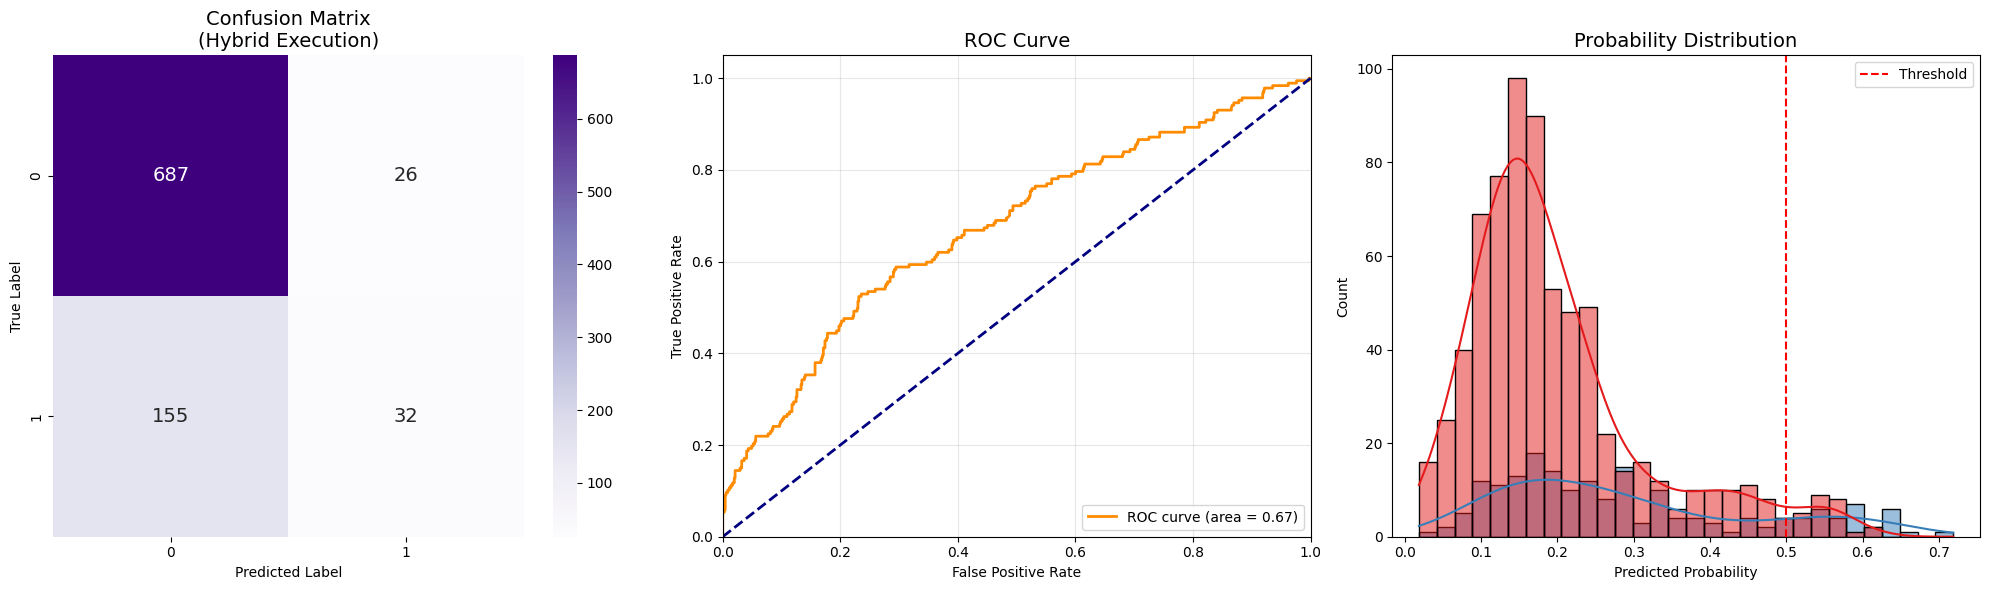

In [12]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from qrisp import QuantumVariable, ry, rz, cx, auto_uncompute
from qrisp.interface import IQMBackend
import os
import time

# --- CONFIGURATION ---
CHECKPOINT_FILE = "real_device_results_weighted_cost.csv"
MAX_HARDWARE_SAMPLES = 60  # Stops utilizing Real QPU after 60 samples to save credits
SAVE_EVERY = 10            # Save progress to CSV every 10 samples



# --- 1. RE-VERIFY DATA (Safety Check) ---
# Ensure X_test and y_test correspond to the same split as training
print("--- 1. Preparing Data ---")
X = cleaned_credit_df.drop('loan_status', axis=1).values
y = cleaned_credit_df['loan_status'].values

X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)
minmax = MinMaxScaler(feature_range=(0, np.pi))
X_final = minmax.fit_transform(X_pca)

# Re-create split to ensure consistency
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42)
print(f"Testing on {len(X_test)} samples.")


# 1. DELETE OLD CONNECTION (Clear from memory)
if 'sirius_backend' in locals():
    del sirius_backend

# 2. FORCE RECONNECT (Unconditional)
print("🔄 Forcing new connection to IQM Sirius...")

# PASTE YOUR NEW, CREDITED TOKEN HERE
NEW_TOKEN = "itoNvhF2HhbwJoUU7WcAoRl91Rm/+fxHQY6uN2Uj1C8BmxnryoF5AYrP01BPv/X2"

try:
    sirius_backend = IQMBackend(api_token=NEW_TOKEN, device_instance="sirius")
    print("✅ Success! Connected with NEW credentials.")
except Exception as e:
    print(f"❌ Connection failed: {e}")

# --- 3. QUANTUM CIRCUIT DEFINITION ---
num_qubits = 4
depth = 2

def qrisp_circuit(data_point, params, backend=None, shots=100):
    qv = QuantumVariable(num_qubits)

    # Feature Map
    for i in range(num_qubits):
        ry(data_point[i], qv[i])

    # Ansatz
    param_idx = 0
    for d in range(depth):
        for i in range(num_qubits - 1):
            cx(qv[i], qv[i+1])
        for i in range(num_qubits):
            ry(params[param_idx], qv[i])
            rz(params[param_idx + 1], qv[i])
            param_idx += 2

    # Measure
    if backend:
        # Real Hardware (Batched/Remote)
        res = qv.get_measurement(backend=backend, shots=shots)
    else:
        # Simulator (Local)
        res = qv.get_measurement()

    # Marginalize
    prob_1 = 0.0
    for outcome_str, p in res.items():
        if outcome_str[0] == "1":
            prob_1 += p

    return prob_1

# --- 4. HYBRID INFERENCE LOOP ---
print(f"\n🚀 Starting Hybrid Inference on {len(X_test)} samples...")
print(f"• First {MAX_HARDWARE_SAMPLES} samples -> Real Quantum Hardware")
print(f"• Remaining samples -> Simulator")
print(f"💾 Saving to '{CHECKPOINT_FILE}'")

# Load existing progress
inference_results = []
if os.path.exists(CHECKPOINT_FILE):
    print("📂 Resuming from checkpoint...")
    inference_results = pd.read_csv(CHECKPOINT_FILE).to_dict('records')
    processed_indices = {row['index'] for row in inference_results}
else:
    processed_indices = set()

try:
    for i, point in tqdm(enumerate(X_test), total=len(X_test)):

        if i in processed_indices:
            continue

        prob = 0.0
        source = "simulator"

        # LOGIC: Hardware vs Simulator
        if i < MAX_HARDWARE_SAMPLES and sirius_backend:
            # --- TRY REAL HARDWARE ---
            try:
                prob = qrisp_circuit(point, optimal_params, backend=sirius_backend, shots=100)
                source = "iqm_sirius"
            except Exception as e:
                print(f"⚠️ Sample {i} Hardware Error: {e}. Switching to Simulator.")
                prob = qrisp_circuit(point, optimal_params, backend=None)
                source = "simulator_fallback"
        else:
            # --- USE SIMULATOR ---
            prob = qrisp_circuit(point, optimal_params, backend=None)
            source = "simulator"

        # Store
        inference_results.append({
            'index': i,
            'true_label': y_test[i],
            'prob_1': prob,
            'source': source
        })

        # Checkpoint
        if (i + 1) % SAVE_EVERY == 0:
            pd.DataFrame(inference_results).to_csv(CHECKPOINT_FILE, index=False)

except KeyboardInterrupt:
    print("\n🛑 Execution paused by user. Saving data...")

# Final Save
results_df = pd.DataFrame(inference_results)
results_df.to_csv(CHECKPOINT_FILE, index=False)
print("✅ Hybrid Inference Complete.")

# --- 5. ANALYTICS & GRAPHICS ---

if not results_df.empty:
    y_true = results_df['true_label']
    y_probs = results_df['prob_1']
    y_pred = np.where(y_probs > 0.5, 1, 0)

    # Check if we have mixed sources
    hw_count = len(results_df[results_df['source'] == 'iqm_sirius'])
    sim_count = len(results_df) - hw_count

    print("\n" + "="*40)
    print("🏆 HYBRID MODEL REPORT")
    print("="*40)
    print(f"Total Samples:     {len(results_df)}")
    print(f"Real Quantum Runs: {hw_count}")
    print(f"Simulated Runs:    {sim_count}")

    # METRICS
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_probs)
    gini = 2 * roc_auc - 1

    print("-" * 40)
    print(f"Accuracy:          {acc:.4f}")
    print(f"F1 Score:          {f1:.4f}")
    print(f"ROC-AUC Score:     {roc_auc:.4f}")
    print(f"Gini Coefficient:  {gini:.4f}")
    print("-" * 40)
    print(classification_report(y_true, y_pred))

    # PLOTS
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # A. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=axes[0], annot_kws={"size": 14})
    axes[0].set_title("Confusion Matrix\n(Hybrid Execution)", fontsize=14)
    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")

    # B. ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve', fontsize=14)
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # C. Prediction Histogram
    sns.histplot(data=results_df, x='prob_1', hue='true_label', bins=30, kde=True, ax=axes[2], palette='Set1')
    axes[2].set_title("Probability Distribution", fontsize=14)
    axes[2].set_xlabel("Predicted Probability")
    axes[2].axvline(0.5, color='red', linestyle='--', label='Threshold')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

else:
    print("❌ No results found in dataframe.")

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from qrisp import QuantumVariable, ry, rz, cx

# --- 1. Define Circuit (Same as your model) ---
num_qubits = 4
depth = 2

def build_circuit_for_drawing(data_point, params):
    qv = QuantumVariable(num_qubits)

    # Feature Map
    for i in range(num_qubits):
        ry(data_point[i], qv[i])

    # Ansatz
    param_idx = 0
    for d in range(depth):
        for i in range(num_qubits - 1):
            cx(qv[i], qv[i+1])
        for i in range(num_qubits):
            ry(params[param_idx], qv[i])
            rz(params[param_idx + 1], qv[i])
            param_idx += 2

    return qv

# --- 2. Generate Dummy Data ---
dummy_data = np.random.uniform(0, np.pi, num_qubits)
dummy_params = np.random.uniform(0, 2*np.pi, num_qubits * 2 * depth)

# --- 3. Build & Compile ---
qv_instance = build_circuit_for_drawing(dummy_data, dummy_params)
compiled_circuit = qv_instance.qs.compile()  # <--- CRITICAL FIX

# --- 4. Plotting ---

print("=== Text Diagram ===")
print(compiled_circuit)  # Prints ASCII art

print("\n=== Professional Diagram ===")
try:
    # Use Matplotlib to draw the compiled circuit
    fig = compiled_circuit.draw(output="mpl")
    plt.title("Variational Quantum Classifier (4 Qubits)")
    plt.show()
except Exception as e:
    print(f"Graph error: {e}")
    print("Fallback: Use the ASCII art above for your report.")

=== Text Diagram ===
      ┌─────────────┐     ┌────────────┐┌────────────┐               »
qv.0: ┤ Ry(0.75367) ├──■──┤ Ry(4.6092) ├┤ Rz(4.4452) ├───────────────»
      └┬────────────┤┌─┴─┐└────────────┘├────────────┤ ┌────────────┐»
qv.1: ─┤ Ry(2.5651) ├┤ X ├──────■───────┤ Ry(0.7228) ├─┤ Rz(5.1405) ├»
       ├────────────┤└───┘    ┌─┴─┐     └────────────┘┌┴────────────┤»
qv.2: ─┤ Ry(2.5118) ├─────────┤ X ├───────────■───────┤ Ry(0.57886) ├»
      ┌┴────────────┤         └───┘         ┌─┴─┐     └┬────────────┤»
qv.3: ┤ Ry(0.88881) ├───────────────────────┤ X ├──────┤ Ry(4.1785) ├»
      └─────────────┘                       └───┘      └────────────┘»
«                    ┌────────────┐┌─────────────┐                             
«qv.0: ──────■───────┤ Ry(5.9661) ├┤ Rz(0.56133) ├─────────────────────────────
«          ┌─┴─┐     └────────────┘└┬────────────┤ ┌────────────┐              
«qv.1: ────┤ X ├───────────■────────┤ Ry(2.0393) ├─┤ Rz(2.0501) ├──────────────
«      ┌───┴───┴───┐

In [25]:
# Optimal Parameters: [3.08876361 0.67005237 6.67699832 1.3852967  2.64512412 3.87247199
# 4.16930266 2.62345424 5.61390639 3.0569249  3.46614624 3.94629041
# 3.80050533 5.41457248 5.58088954 3.63598565]
qv_vis = build_qrisp_circuit(X_test[0], optimal_params)
qc = qv_vis.to_qiskit()
qc.draw("mpl")

AttributeError: 'QuantumVariable' object has no attribute 'to_qiskit'